## ĐỒ ÁN CUỐI KÌ DS106.

## Chuẩn bị dữ liệu

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# 1. Bộ dữ liệu
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


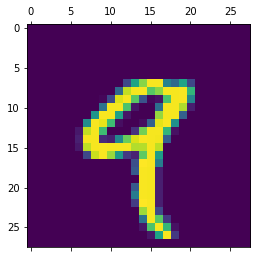

In [3]:
plt.matshow(X_train[4])

In [4]:
# Kich thuoc du lieu test.
y_train.shape
X_train.shape

(60000, 28, 28)

In [5]:
# 2. Chuẩn bị dữ liệu.
from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split(X_train,
y_train, test_size=0.1)

In [6]:
# Reshape data:
X_train_reshaped = X_train.reshape(-1, 784)
X_dev_reshaped = X_dev.reshape(-1, 784)
X_test_reshaped = X_test.reshape(-1, 784)

In [7]:
X_train_reshaped.shape

(54000, 784)

In [8]:
# Chuẩn bị y_train và y_dev:
from tensorflow.keras.utils import to_categorical
y_train_new = to_categorical(y_train,num_classes=10)
y_dev_new = to_categorical(y_dev, num_classes = 10)

In [9]:
y_train_new.shape

(54000, 10)

## Thực hiện thực nghiệm mô hình và dữ liệu trên bộ dữ với optimizer = Adamp.

In [10]:
"""AdamP for TensorFlow."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops


class AdamP(optimizer_v2.OptimizerV2):
    _HAS_AGGREGATE_GRAD = True

    def __init__(self,
                 learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-8,
                 weight_decay=0.0,
                 delta=0.1, wd_ratio=0.1, nesterov=False,
                 name='AdamP',
                 **kwargs):

        super(AdamP, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self._set_hyper('delta', delta)
        self._set_hyper('wd_ratio', wd_ratio)

        self.epsilon = epsilon or backend_config.epsilon()
        self.weight_decay = weight_decay
        self.nesterov = nesterov

    def _create_slots(self, var_list):
        # Create slots for the first and second moments.
        # Separate for-loops to respect the ordering of slot variables from v1.
        for var in var_list:
            self.add_slot(var, 'm')
        for var in var_list:
            self.add_slot(var, 'v')
        for var in var_list:
            self.add_slot(var, 'p')

    def _prepare_local(self, var_device, var_dtype, apply_state):
        super(AdamP, self)._prepare_local(var_device, var_dtype, apply_state)

        local_step = math_ops.cast(self.iterations + 1, var_dtype)
        beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
        beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
        beta_1_power = math_ops.pow(beta_1_t, local_step)
        beta_2_power = math_ops.pow(beta_2_t, local_step)

        lr = apply_state[(var_device, var_dtype)]['lr_t']
        bias_correction1 = 1 - beta_1_power
        bias_correction2 = 1 - beta_2_power

        delta = array_ops.identity(self._get_hyper('delta', var_dtype))
        wd_ratio = array_ops.identity(self._get_hyper('wd_ratio', var_dtype))

        apply_state[(var_device, var_dtype)].update(
            dict(
                lr=lr,
                epsilon=ops.convert_to_tensor_v2(self.epsilon, var_dtype),
                weight_decay=ops.convert_to_tensor_v2(self.weight_decay, var_dtype),
                beta_1_t=beta_1_t,
                beta_1_power=beta_1_power,
                one_minus_beta_1_t=1 - beta_1_t,
                beta_2_t=beta_2_t,
                beta_2_power=beta_2_power,
                one_minus_beta_2_t=1 - beta_2_t,
                bias_correction1=bias_correction1,
                bias_correction2=bias_correction2,
                delta=delta,
                wd_ratio=wd_ratio))

    def set_weights(self, weights):
        params = self.weights
        # If the weights are generated by Keras V1 optimizer, it includes vhats
        # optimizer has 2x + 1 variables. Filter vhats out for compatibility.
        num_vars = int((len(params) - 1) / 2)
        if len(weights) == 3 * num_vars + 1:
            weights = weights[:len(params)]
        super(AdamP, self).set_weights(weights)

    def _resource_apply_dense(self, grad, var, apply_state=None):
        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))

        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
        m_t = state_ops.assign(m, m * coefficients['beta_1_t'] + m_scaled_g_values, use_locking=self._use_locking)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
        v_t = state_ops.assign(v, v * coefficients['beta_2_t'] + v_scaled_g_values, use_locking=self._use_locking)

        denorm = (math_ops.sqrt(v_t) / math_ops.sqrt(coefficients['bias_correction2'])) + coefficients['epsilon']
        step_size = coefficients['lr'] / coefficients['bias_correction1']

        if self.nesterov:
            perturb = (coefficients['beta_1_t'] * m_t + coefficients['one_minus_beta_1_t'] * grad) / denorm
        else:
            perturb = m_t / denorm

        # Projection
        wd_ratio = 1
        if len(var.shape) > 1:
            perturb, wd_ratio = self._projection(var, grad, perturb, coefficients['delta'], coefficients['wd_ratio'], coefficients['epsilon'])

        # Weight decay

        if self.weight_decay > 0:
            var = state_ops.assign(var, var * (1 - coefficients['lr'] * coefficients['weight_decay'] * wd_ratio), use_locking=self._use_locking)

        var_update = state_ops.assign_sub(var, step_size * perturb, use_locking=self._use_locking)

        return control_flow_ops.group(*[var_update, m_t, v_t])


    def _resource_apply_sparse(self, grad, var, indices, apply_state=None):

        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))
        """
        Adam
        """
        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
        m_t = state_ops.assign(m, m * coefficients['beta_1_t'],
                               use_locking=self._use_locking)
        with ops.control_dependencies([m_t]):
            m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
        v_t = state_ops.assign(v, v * coefficients['beta_2_t'],
                               use_locking=self._use_locking)
        with ops.control_dependencies([v_t]):
            v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)

        denorm = (math_ops.sqrt(v_t) / math_ops.sqrt(coefficients['bias_correction2'])) + coefficients['epsilon']
        step_size = coefficients['lr'] / coefficients['bias_correction1']

        if self.nesterov:
            p_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
            perturb = m_t * coefficients['beta_1_t']
            perturb = self._resource_scatter_add(perturb, indices, p_scaled_g_values) / denorm

        else:
            perturb = m_t / denorm

        # Projection
        wd_ratio = 1
        if len(var.shape) > 1:
            perturb, wd_ratio = self._projection(var, grad, perturb, coefficients['delta'], coefficients['wd_ratio'], coefficients['epsilon'])

        # Weight decay
        if self.weight_decay > 0:
            var = state_ops.assign(var, var * (1 - coefficients['lr'] * coefficients['weight_decay'] * wd_ratio), use_locking=self._use_locking)

        var_update = state_ops.assign_sub(var, step_size * perturb, use_locking=self._use_locking)

        return control_flow_ops.group(*[var_update, m_t, v_t])

    def _channel_view(self, x):
        return array_ops.reshape(x, shape=[x.shape[0], -1])

    def _layer_view(self, x):
        return array_ops.reshape(x, shape=[1, -1])

    def _cosine_similarity(self, x, y, eps, view_func):
        x = view_func(x)
        y = view_func(y)

        x_norm = math_ops.euclidean_norm(x, axis=-1) + eps
        y_norm = math_ops.euclidean_norm(y, axis=-1) + eps
        dot = math_ops.reduce_sum(x * y, axis=-1)

        return math_ops.abs(dot) / x_norm / y_norm

    def _projection(self, var, grad, perturb, delta, wd_ratio, eps):
        # channel_view
        cosine_sim = self._cosine_similarity(grad, var, eps, self._channel_view)
        cosine_max = math_ops.reduce_max(cosine_sim)
        compare_val = delta / math_ops.sqrt(math_ops.cast(self._channel_view(var).shape[-1], dtype=delta.dtype))

        perturb, wd = control_flow_ops.cond(pred=cosine_max < compare_val,
                                            true_fn=lambda : self.channel_true_fn(var, perturb, wd_ratio, eps),
                                            false_fn=lambda : self.channel_false_fn(var, grad, perturb, delta, wd_ratio, eps))

        return perturb, wd

    def channel_true_fn(self, var, perturb, wd_ratio, eps):
        expand_size = [-1] + [1] * (len(var.shape) - 1)
        var_n = var / (array_ops.reshape(math_ops.euclidean_norm(self._channel_view(var), axis=-1), shape=expand_size) + eps)
        perturb -= var_n * array_ops.reshape(math_ops.reduce_sum(self._channel_view(var_n * perturb), axis=-1), shape=expand_size)
        wd = wd_ratio

        return perturb, wd

    def channel_false_fn(self, var, grad, perturb, delta, wd_ratio, eps):
        cosine_sim = self._cosine_similarity(grad, var, eps, self._layer_view)
        cosine_max = math_ops.reduce_max(cosine_sim)
        compare_val = delta / math_ops.sqrt(math_ops.cast(self._layer_view(var).shape[-1], dtype=delta.dtype))

        perturb, wd = control_flow_ops.cond(cosine_max < compare_val,
                                              true_fn=lambda : self.layer_true_fn(var, perturb, wd_ratio, eps),
                                              false_fn=lambda : self.identity_fn(perturb))

        return perturb, wd

    def layer_true_fn(self, var, perturb, wd_ratio, eps):
        expand_size = [-1] + [1] * (len(var.shape) - 1)
        var_n = var / (array_ops.reshape(math_ops.euclidean_norm(self._layer_view(var), axis=-1), shape=expand_size) + eps)
        perturb -= var_n * array_ops.reshape(math_ops.reduce_sum(self._layer_view(var_n * perturb), axis=-1), shape=expand_size)
        wd = wd_ratio

        return perturb, wd

    def identity_fn(self, perturb):
        wd = 1.0

        return perturb, wd

    def get_config(self):
        config = super(AdamP, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'beta_1': self._serialize_hyperparameter('beta_1'),
            'beta_2': self._serialize_hyperparameter('beta_2'),
            'delta': self._serialize_hyperparameter('delta'),
            'wd_ratio': self._serialize_hyperparameter('wd_ratio'),
            'epsilon': self.epsilon,
            'weight_decay': self.weight_decay,
            'nesterov': self.nesterov
        })
        return config
1

1

In [11]:
optimizer_adamp = AdamP(learning_rate=0.001, beta_1=0.9, beta_2=0.999, weight_decay=1e-2)


In [12]:
from tensorflow.python.ops import state_ops

In [13]:
import tensorflow.python.ops.state_ops

In [14]:
# 3. Huấn luyện mô hình.
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.losses import CategoricalCrossentropy 
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.keras.metrics import Accuracy
model = Sequential()

model.add(Dense(784, input_shape=(784, ),
                activation='relu'
                #kernel_regularizer = l2(0.01),
                #bias_regularizer= l2(0.01))
))
model.add(Dense(10, input_shape=(10, ),
                activation='sigmoid'
                #kernel_regularizer= l2(0.01),
                #bias_regularizer= l2(0.01) )
))

optimizer = optimizer_adamp
loss = CategoricalCrossentropy()
metrics = Accuracy()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Chay mo hinh
history = model.fit(X_train_reshaped, y_train_new,
validation_data=(X_dev_reshaped,y_dev_new) ,batch_size=128, epochs=100)

Epoch 1/100
422/422 [==============================] - 11s 10ms/step - loss: 4.4496 - accuracy: 0.1968 - val_loss: 1.0215 - val_accuracy: 0.1153
Epoch 2/100
422/422 [==============================] - 4s 9ms/step - loss: 0.5145 - accuracy: 0.1073 - val_loss: 0.6740 - val_accuracy: 0.1039
Epoch 3/100
422/422 [==============================] - 4s 9ms/step - loss: 0.2829 - accuracy: 0.1035 - val_loss: 0.5819 - val_accuracy: 0.1068
Epoch 4/100
422/422 [==============================] - 3s 6ms/step - loss: 0.2035 - accuracy: 0.1023 - val_loss: 0.4990 - val_accuracy: 0.1003
Epoch 5/100
422/422 [==============================] - 3s 6ms/step - loss: 0.1633 - accuracy: 0.1032 - val_loss: 0.5176 - val_accuracy: 0.1015
Epoch 6/100
422/422 [==============================] - 3s 6ms/step - loss: 0.1830 - accuracy: 0.1041 - val_loss: 0.6507 - val_accuracy: 0.1042
Epoch 7/100
422/422 [==============================] - 3s 6ms/step - loss: 0.1842 - accuracy: 0.1053 - val_loss: 0.4758 - val_accuracy: 0.10

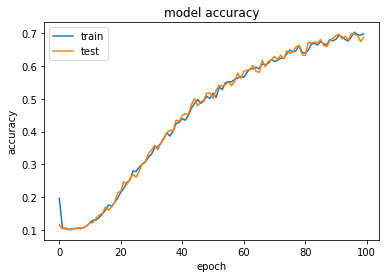

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

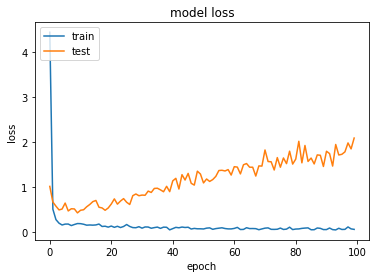

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
